# Financial Asset Recommender: Profitability Predication

## Introduction

This notebook is aimed to serve as an introduction to the creation of a recommender that operates on an open dataset of stock market prices in order to recommend profitable assets. It covers the data download and processing steps, the calculation of the features fed into the prediction model, and finally a simple model that predicts the profitability of assets to rank them. 

Before we get started, we need to confgure where we are to store the dataset and models produced. If you are running this notebook locally, then any folder on your machine should be fine. If you are working within a container, you may need to change the directory to a mounted writable file system.

In [9]:
# Local Mode
storageDIR = "dataset" # creates a dataset directory in the same folder as the notebook

# Container Mode
#storageDIR = "/tmp/dataset" # creates a dataset directory in the /tmp/ directory for the container

## Dataset

Different types of financial asset recommendation system use different types of data to prodice their recommendations. This approach is known as Profitability Prediction, where assets that are predicted to gain significant value over the following year are recommended. This type of approach uses past pricing data, i.e. the price for different assets over time to identify pricing trends and hence future profitable assets. Hence, as input we need a dataset that for a range of assets contains their price history over time.

For illustration, in this notebook we will use an open dataset, although you may wish to swap this for data from your market of choice. The dataset used here is the Huge Stock Market Dataset compiled by Boris Marjanovic, and is publically available <b><a href='https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs'>here</a>.</b>

The dataset comprises historical price and volume data for all US-based stocks and ETFs trading on the NYSE, NASDAQ, and NYSE markets, and runs up to the last quarter of 2017. For each financial asset (stock or ETF), it contains a series of price entries describing the market price of that asset on different days. Each entry is comprised of:
 - Date: The date of the pricing data 
 - Open: Opening price for that day
 - High: The maximum price for that day
 - Low: The minimum price for that day
 - Close: The closing price for that day
 - Volume: The amount of the asset that is traded 
 - OpenInt: The total number of outstanding contracts held by market participants

## Downloading the Dataset

This dataset can be downloaded through the <b><a href='https://github.com/Kaggle/kaggle-api'>Kaggle API</a></b>. Users should make an account on the Kaggle website and download an API token in order to access this dataset on their local machine. This is available from the Account section of the Kaggle user profile.

To use the Kaggle API, we first install the package through pip. We then export the username and the API key from the aforementioned token, and use the download command to fetch and unzip the dataset. For our current experiment we will use only the set of Stocks.

(The below commands can also be entered directly into your terminal, without the ! prefix.)

In [21]:
import os
os.environ["KAGGLE_USERNAME"] = "yourKaggleUsername"
os.environ["KAGGLE_KEY"] = "yourKaggleAPIKey"

!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('borismarjanovic/price-volume-data-for-all-us-stocks-etfs', path=storageDIR)
print("Download Complete")

Download Complete


## Extracting and Loading the Dataset

After downloading the dataset we need to extract the files and then convert it into a Pandas DataFrame, which is somewhat like a large data table that makes the raw data easier to analyse. 

In [4]:
import zipfile
import pandas as pd
import numpy as np
import glob, os, random, math

# Unzip the Dataset
with zipfile.ZipFile(storageDIR+"/price-volume-data-for-all-us-stocks-etfs.zip", 'r') as zip_ref:
    zip_ref.extractall(storageDIR)

# Replace this with your dataset path
path = storageDIR+'/Stocks/' 
all_files = glob.glob(os.path.join(path, "*.us.txt"))
dfs = []

# Iterating through files and only using non-empty files
for f in all_files:
    if os.path.getsize(f) > 0:
        df = pd.read_csv(f) 
        df['Stock'] = f.split('/')[-1].split('.')[0]
        dfs.append(df)
full_kaggle_df = pd.concat(dfs)

print("Dataset Extraction and Loading as Dataframe Complete")

Dataset Extraction and Loading as Dataframe Complete


## Filtering the Dataset

Pandas allows us to perform manipulations on the pricing data so that we can extract only what we need for training the model. For the purpose of our illustration, we will only use pricing data from 2016 and 2017, where we consider 2016 as the 'past' and hence we can use that period for learning what assets are likely to be profitable, and 2017 as the future (which we will use to test how well our model performs later). In effect, for our experiment here we can consider an the date of asset recommendation to be the 1st of January 2017. 

Lets first filter the dataset to only hold data from the dates we care about:

In [5]:
# We only require the date, stock name, and closing price for that day
full_kaggle_df = full_kaggle_df[['Date', 'Close', 'Stock']]
full_kaggle_df['Date'] = pd.to_datetime(full_kaggle_df['Date'])
full_kaggle_df['year'] = full_kaggle_df['Date'].dt.year
full_kaggle_df['month'] = full_kaggle_df['Date'].dt.month
full_kaggle_df['day'] = full_kaggle_df['Date'].dt.day

# Selecting only that data from either 2016 or 2017
full_kaggle_df = full_kaggle_df[(full_kaggle_df['year'] >= 2016)].drop(columns=['year', 'month', 'day'])
full_kaggle_df['Date'] = full_kaggle_df['Date'].dt.strftime('%Y-%m-%d')

print("Dataset Filtering Complete")

## Weekly Price Change Calculation

Now that we have our data, we need to convert it into a form that makes it easier to work with. In this case, we can convert pricing data over time into weekly price changes for each asset. This makes the data more closely match what we want as output, while also enabling data normalization over the daily price points (which can help avoid outliers and in cases where particular days are missing in the data). In particular, we find the closing price for each stock as per the Monday of each week. We calculate the weekly return of each stock after aggregating close prices weekly. This is defined as the percentage change in the weekly prices and is represented as follows:

\begin{equation}
WeeklyChange = \frac{Current \ closing \ price \ - \ Preceding \ closing \ price}{Preceding \ closing \ price}
\end{equation}

Note that this step can take some time...


In [6]:
stocks = full_kaggle_df['Stock'].unique().tolist()
pricedfs = []
for s in stocks:
    df = full_kaggle_df[full_kaggle_df['Stock'] == s]
    df['Date'] = pd.to_datetime(df['Date']) - pd.to_timedelta(7, unit='d')
    
    #Grouping close prices weekly
    df = df.groupby(['Stock', pd.Grouper(key='Date', freq='W-MON')])['Close'].nth(-1).reset_index().sort_values('Date')

    #Calculating percentage change in asset prices as returns
    df['returns'] = df['Close'].pct_change()
    df['returns'] = df['returns'].replace([np.inf, -np.inf], np.nan)
    df['returns'] = df['returns'].fillna(df['returns'].mean())
    
    df = df.iloc[1:]
    pricedfs.append(df)
    
print("Dataset Price Changes Extracted")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Below we show a sample DataFrame with weekly returns calculated.

In [7]:
pricedfs[0].head()

,Stock,Date,Close,returns
1,Stocks\a,2016-01-04,37.278,-0.067560
2,Stocks\a,2016-01-11,36.463,-0.021863
3,Stocks\a,2016-01-18,36.952,0.013411
4,Stocks\a,2016-01-25,37.031,0.002138
5,Stocks\a,2016-02-01,34.193,-0.076638


We then filter the dataframes with 2016 pricing data for training purposes and those with 9 months of 2017 pricing data for testing, and take a random sample of 1000 assets from the filtered subset to speed up the experiment.

In [10]:
# Filtering those dataframes with 2016 pricing data for training
newdfs_training = []

for d in pricedfs:
    d['Date'] = pd.to_datetime(d['Date'])
    d['year'] = d['Date'].dt.year
    d['month'] = d['Date'].dt.month
    d['day'] = d['Date'].dt.day

    d = d[(d['year'] == 2016)].drop(columns=['year', 'month', 'day'])
    d['Date'] = d['Date'].dt.strftime('%Y-%m-%d')
    if d.shape[0] >= 52:
        newdfs_training.append(d)
        
#Randomly sampling assets
random.seed(20)
newdfs_training = random.sample(newdfs_training, 1000)

# ==============================================================
# Filtering those dataframes with 2017 pricing data for testing

newdfs_test = []

for d in pricedfs:
    d['Date'] = pd.to_datetime(d['Date'])
    d['year'] = d['Date'].dt.year
    d['month'] = d['Date'].dt.month
    d['day'] = d['Date'].dt.day

    d = d[(d['year'] == 2017) & ((d['month'] != 10) & (d['month'] != 11) & 
                                 (d['month'] != 12))].drop(columns=['year', 'month', 'day'])
    d['Date'] = d['Date'].dt.strftime('%Y-%m-%d')
    if d.shape[0] >= 39:
        newdfs_test.append(d)
        
#Randomly sampling assets
random.seed(20)
newdfs_test = random.sample(newdfs_test, 1000)

print("Dataset Divided into Training and Test Sets")

## Feature Creation for the Model

Now that we have the pricing data in a more useful form, we can now convert that data into additional indicators that a machine learned model can use for identifying patterns/trends. In effect, we want to capture how the price for an asset changed in the recent past, for use as indicators for future performance (of course past performance is not always a good indicator, and more advanced approaches may mix in other sources of evidence here). We convert the pricing data into three main indicator (feature) types:

<ul>
    <li> Average closing price </li>
    <li> Return on Investment </li>
    <li> Volatility </li>
</ul>

These are calculated over the last 3, 6, and 9 months from the point in time at which recommendations are requested.

Returns are calculated as follows over each specified period:

\begin{equation}
Return On Investment = \frac{Final \ closing \ price \ - \ Initial \ closing \ price}{Initial \ closing \ price}
\end{equation}

Volatility represent the risk of a stock as expressed by its fluctuations, and is expressed as the standard deviation of the returns of the stock. As our returns are calculated weekly, we also ensure our volatilities are converted into 3-month, 6-month, and 9-month estimates.

\begin{equation}
Volatility = \sqrt{\frac{1}{N-1} \sum_{i=1}^N (Return_i - \overline{Return})^2} * \sqrt{Number \ of \ weeks}
\end{equation}


In [12]:

def calculate_features(newdfs):
    dfs = []
    for d in newdfs:
        d['Date'] = pd.to_datetime(d['Date'])
        df3m = d.set_index('Date').last('3M')
        d['avg_price_3m'] = df3m['Close'].mean()
        d['volatility_3m'] = df3m['returns'].std() * math.sqrt(13.0357)
        d['returns_3m'] = (df3m.tail(1)['Close'].values[0] - df3m.head(1)['Close'].values[0])/df3m.head(1)['Close'].values[0]

        df6m = d.set_index('Date').last('6M')
        d['avg_price_6m'] = df6m['Close'].mean()
        d['volatility_6m'] = df6m['returns'].std() * math.sqrt(26.0715)
        d['returns_6m'] = (df6m.tail(1)['Close'].values[0] - df6m.head(1)['Close'].values[0])/df6m.head(1)['Close'].values[0]

        df9m = d.set_index('Date').last('9M')
        d['avg_price_9m'] = df9m['Close'].mean()
        d['volatility_9m'] = df9m['returns'].std() * math.sqrt(39.1072)
        d['returns_9m'] = (df9m.tail(1)['Close'].values[0] - df9m.head(1)['Close'].values[0])/df9m.head(1)['Close'].values[0]

        d = d.head(1)
        dfs.append(d)

    all_feature_dfs = pd.concat(dfs)
    all_feature_dfs = all_feature_dfs.drop(columns=['Date', 'Close', 'returns'])
    all_feature_dfs.dropna(inplace=True)
    return all_feature_dfs


training_data = calculate_features(newdfs_training)

# Enter your training dataset path here
training_data.to_csv(storageDIR+'/Kaggle-2016-Training-Final.csv')

test_data = calculate_features(newdfs_test)

# Enter your test dataset path here
test_data.to_csv(storageDIR+'/Kaggle-2017-Test-Final.csv')

print("Dataset Pricing Trend Features Extracted")


Dataset Pricing Trend Features Extracted


## Profitability prediction model - Random forest regression

After having curated our training and testing sets, we proceed to use a simple machine learning model to predict the 9-month profitability of assets from the test dataset. The model we choose is a Random Forest model. This is imported from the Scikit-Learn library, which is a commonly used package for introductory machine learning experiments and houses a wide variety of models. A random forest regression model is an ensemble model, which means that it combines the predictions of multiple machine learning models in order to improve prediction accuracy and avoid overfitting. A random forest model aggregates decision trees and takes the average of their predictions or probabilities for classes; decision trees are supervised models that attempt to infer simple decision rules from the features and use these to make predictions.

Random forests introduce randomness from two other sources, namely that each tree is built with a random sample from the training set, and that the splitting of nodes during tree construction is either found from all features or from a random subset of the maximum permitted number of features. These sources of randomness are intended to minimize the impact of each singular decision tree's sensitivity. 

Here, we use the training and test data we just prepared and apply a scaler to them so that their values are standardized for prediction. We then apply a random forest regressor model with 500 estimators (decision trees) to calculate predicted returns over a 9-month period. 

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Using precomputed data
training_data = pd.read_csv(storageDIR+'/Kaggle-2016-Training-Final.csv')
test_data = pd.read_csv(storageDIR+'/Kaggle-2017-Test-Final.csv')

train_instrument_ids = training_data['Stock']
returns_9m = training_data['returns_9m']
training_data = training_data.drop(columns=['Stock', 'returns_9m'])

test_instrument_ids = test_data['Stock']
test_returns_9m = test_data['returns_9m']
test_vol_9m = test_data['volatility_9m']
test_data = test_data.drop(columns=['Stock', 'returns_9m'])

# Scaling data values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(training_data)

scaler = StandardScaler()
scaled_test = scaler.fit_transform(test_data)

# Prediction
model = RandomForestRegressor(n_estimators=500)
model.fit(scaled_data, returns_9m)
pred = model.predict(scaled_test)

pred_df = pd.DataFrame(pred)
pred_df = pred_df.rename(columns={0: 'Predicted returns'})
pred_df['Stock'] = pd.Series(test_instrument_ids)
pred_df['Actual returns (9M)'] = test_returns_9m
pred_df['Actual Volatility (9M)'] = test_vol_9m

## Model Effectiveness Evaluation

After the prediction of returns, we proceed onto the evaluation of our model. We can do so by means of more classical metrics that assess the difference between actual and predicted values; we can also look at the aggregate profitability and volatility of the recommended assets over the test period as a measure of suitability. 

In [15]:
pred_df = pred_df.sort_values(by='Predicted returns', ascending=False)
pred_df.head(10)

,Predicted returns,Stock,Actual returns (9M),Actual Volatility (9M)
298,2.704236,Stocks\zgnx,2.050980,1.940495
224,2.287230,Stocks\abeo,1.933884,0.860671
506,2.263269,Stocks\arwr,1.354497,0.631877
429,2.251566,Stocks\sppi,2.081023,0.620670
398,2.226679,Stocks\wprt,1.488189,0.726520
402,2.224329,Stocks\cyrx,1.966049,0.636090
150,2.199163,Stocks\ensv,0.037037,0.849338
705,2.107315,Stocks\xxii,2.140152,0.738352
772,2.102616,Stocks\qure,0.761017,0.604679
513,2.093745,Stocks\sify,0.942658,0.496918


In the above table, we are showing the top 10 stocks that were predicted to be profitable. The last two columns report the actual return on investment after 9 months and asset volitility. Note that a return value of 1.5 means a 150% return on investment. 

We notice that predicted returns for the top stocks are exceedingly high, which is not ordinary. However, we can also see that the actual returns for these stocks are similar for several of these instances, i.e. the model is not wrong in predicting these as profitable investments in the short term. However, we can also see that the volitility fo these stocks is very high, i.e. these are 'high-risk' assets that may subsequently crash in price. 

We can also analyse the statistics for this predictions across the dataset.

In [16]:
pred_df.describe()

,Predicted returns,Actual returns (9M),Actual Volatility (9M)
count,1000.000000,1000.000000,1000.000000
mean,0.291667,0.117710,0.279499
std,0.545248,0.440275,0.270453
min,-0.858322,-0.998589,0.008209
25%,0.019777,-0.027597,0.108639
50%,0.199883,0.073051,0.210807
75%,0.463422,0.214930,0.364167
max,2.704236,7.232558,3.707981


Here we are able to see the average returns and volatility of the entire test set. 

We can also examine the predicted returns and volatility over the top 1, 5, 10, and 20 stocks, ranked by their predicted profitability. This will serve to provide an idea of how financially feasible our recommendations are, and whether the recommended stocks are an improvement to the average returns of the test set.

In [17]:

ret_vol = pd.DataFrame({'Number of assets': [1, 5, 10, 20], 'Mean returns (9M), in %': [pred_df.head(1)['Actual returns (9M)'].mean(),
                        pred_df.head(5)['Actual returns (9M)'].mean(), 
                        pred_df.head(10)['Actual returns (9M)'].mean(),
                        pred_df.head(20)['Actual returns (9M)'].mean()], 
                        'Mean volatility (9M), in %': [pred_df.head(1)['Actual Volatility (9M)'].mean(), 
                                                pred_df.head(5)['Actual Volatility (9M)'].mean(),
                                                pred_df.head(10)['Actual Volatility (9M)'].mean(),
                                                pred_df.head(20)['Actual Volatility (9M)'].mean()]
                       })
ret_vol['Mean returns (9M), in %'] *= 100
ret_vol['Mean volatility (9M), in %'] *= 100

ret_vol

,Number of assets,"Mean returns (9M), in %","Mean volatility (9M), in %"
0,1,205.098039,194.049514
1,5,178.171489,95.604667
2,10,147.554883,81.056093
3,20,123.460761,77.108316


The returns and volatility for the top stocks, ranked by predicted returns, are far higher than their averages across the test set. This indicates that ranking assets by their predicted returns can produce some highly profitable but risk-laden investment recommendations, which might be suitable for aggressive investors. However, it remains to be seen how much of this is owed to fluctuations and outliers in the data, and perhaps even if there are better ways to capture the returns and volatility of the dataset.

Next, we look at the differences between the actual and predicted returns.

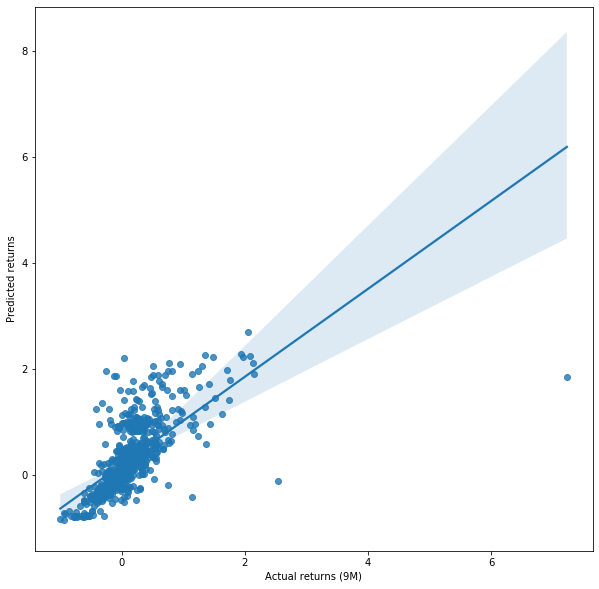

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.regplot(pred_df['Actual returns (9M)'], pred_df['Predicted returns'])
plt.show()

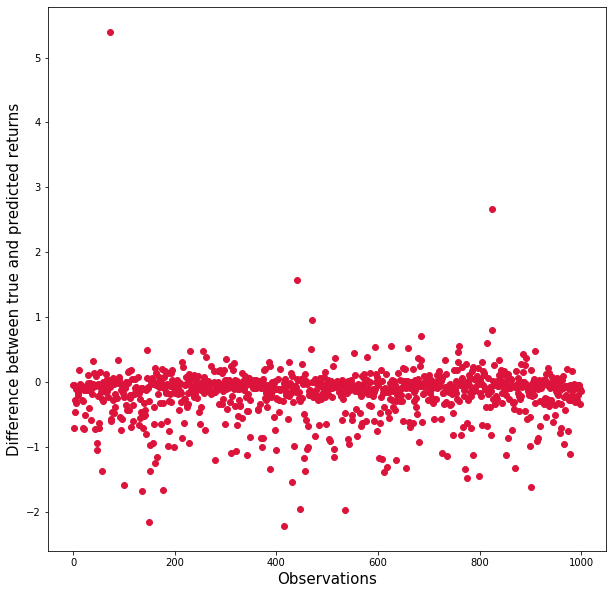

In [19]:
plt.figure(figsize=(10,10))
plt.plot(pred_df['Actual returns (9M)'] - pred_df['Predicted returns'] ,marker='o', linestyle='', c='crimson')
plt.xlabel('Observations', fontsize=15)
plt.ylabel('Difference between true and predicted returns', fontsize=15)
plt.show()

Lastly, we can examine the mean absolute error and mean squared error of the predictions. As these can be quite dependent on the dataset and problem in question, we also assume a simple baseline, by taking the median of all stock returns from the test dataset. We then compare the results of applying these metrics to the baseline and our predictor model.

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


testlist = pd.Series([test_returns_9m.median()]*1000)

mae_mse = pd.DataFrame({'Metric': ['MAE', 'MSE'], 
                        'Baseline (median return)': [mean_absolute_error(pred, testlist),
                                                     mean_squared_error(pred, testlist)], 
                       'Random forest regression': [mean_absolute_error(pred, test_returns_9m), 
                                                   mean_squared_error(pred, test_returns_9m)] 
                       })

mae_mse['Percentage difference'] = (mae_mse['Random forest regression'] - 
                                    mae_mse['Baseline (median return)'])/mae_mse['Baseline (median return)']


mae_mse

,Metric,Baseline (median return),Random forest regression,Percentage difference
0,MAE,0.394475,0.259137,-0.343083
1,MSE,0.344792,0.200128,-0.419568


We can see from this that the random forest model presents an improvement (reduction) in both MAE and MSE.